# Setup

In [32]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [17]:
from albumentations import HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize


def build_augmentation(is_train=True):
    if is_train:  # 훈련용 데이터일 경우
        return Compose([
            HorizontalFlip(p=0.5),  # 50%의 확률로 좌우대칭
            RandomSizedCrop(  # 50%의 확률로 RandomSizedCrop
                min_max_height=(300, 370),
                w2h_ratio=370 / 1242,
                height=224,
                width=224,
                p=0.5),
            Resize(  # 입력이미지를 224X224로 resize
                width=224, height=224)
        ])
    return Compose([  # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
        Resize(width=224, height=224)
    ])

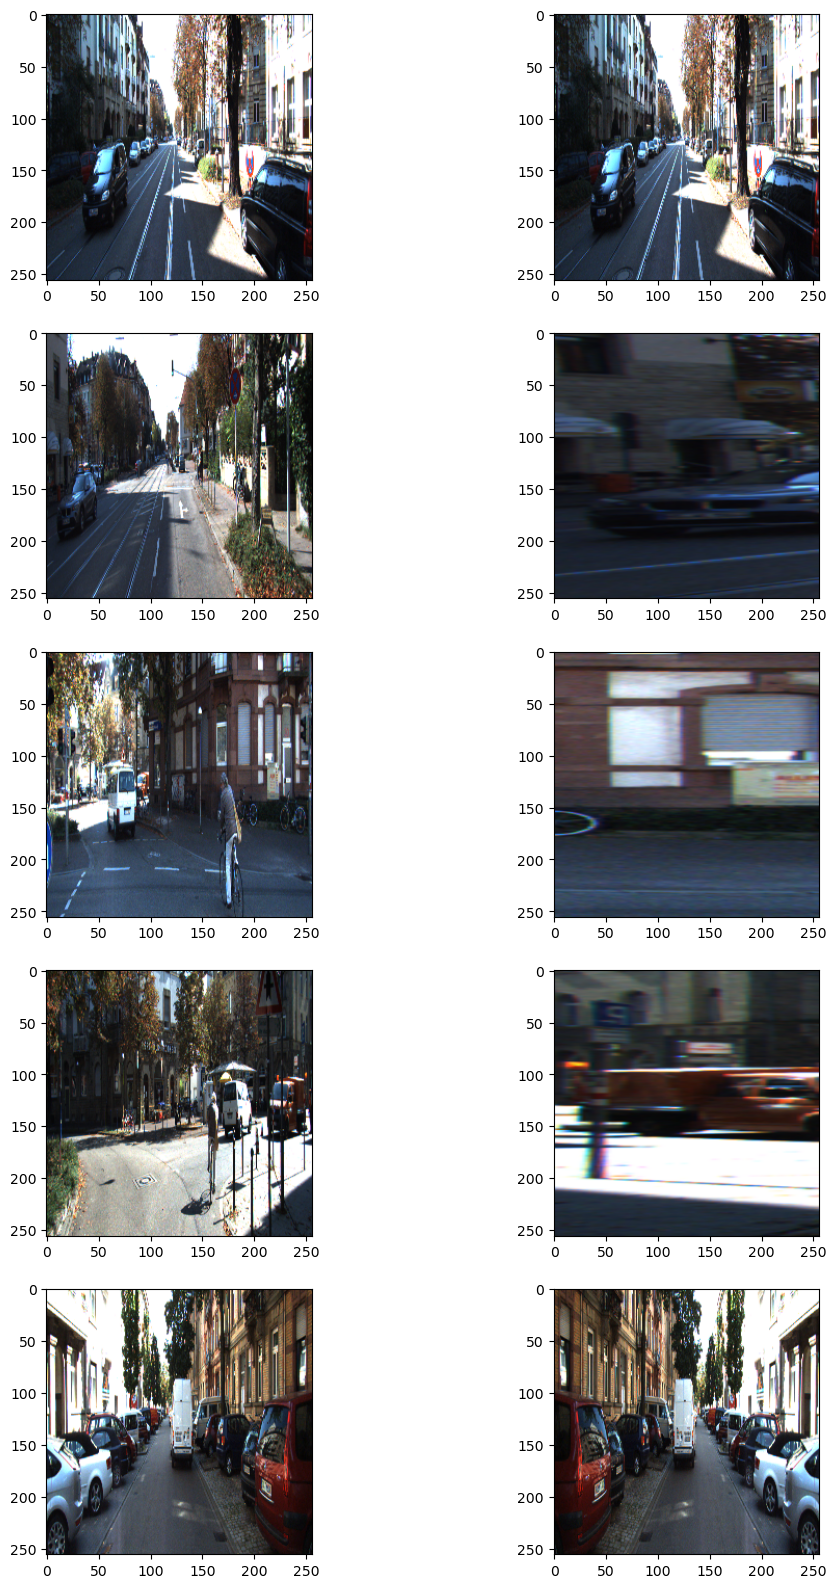

In [3]:
dir_path = 'D:Dataset/dataset/kitti_segmentation/training/'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i])
    image_data = {"image": image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지

plt.show()

In [18]:
class KittiGenerator(tf.keras.utils.Sequence):

    def __init__(self,
                 dir_path,
                 batch_size=8,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [_ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]

    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고
        # 출력은 semantic label입니다.
        batch_data = self.data[index * self.batch_size:(index + 1) *
                               self.batch_size]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output == 7).astype(np.uint8) * 1
            data = {
                "image": _input,
                "mask": _output,
            }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"] / 255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True:
            np.random.shuffle(self.indexes)
            return self.indexes

In [19]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_generator = KittiGenerator(
    dir_path,
    augmentation=augmentation,
)

test_generator = KittiGenerator(dir_path,
                                augmentation=test_preproc,
                                is_train=False)

# Orignial Unet

In [8]:
def build_model(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)
	
  #Contracting Path
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
  
  #Expanding Path
  drop5 = Dropout(0.5)(conv5)
  up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
  up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
  up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
  up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
  conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model

In [9]:
model_path = "./model_save/seg_model_ori_unet.h5"

model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
22/22 [==============================] - 14s 319ms/step - loss: 0.6736 - val_loss: 0.6424
Epoch 2/100
22/22 [==============================] - 7s 307ms/step - loss: 0.2368 - val_loss: 0.0602
Epoch 3/100
22/22 [==============================] - 7s 304ms/step - loss: 0.0680 - val_loss: 0.0706
Epoch 4/100
22/22 [==============================] - 7s 308ms/step - loss: 0.0594 - val_loss: 0.0626
Epoch 5/100
22/22 [==============================] - 7s 305ms/step - loss: 0.0547 - val_loss: 0.0515
Epoch 6/100
22/22 [==============================] - 7s 306ms/step - loss: 0.0480 - val_loss: 0.0681
Epoch 7/100
22/22 [==============================] - 7s 308ms/step - loss: 0.0529 - val_loss: 0.0427
Epoch 8/100
22/22 [==============================] - 7s 304ms/step - loss: 0.0361 - val_loss: 0.0380
Epoch 9/100
22/22 [==============================] - 7s 313ms/step - loss: 0.0472 - val_loss: 0.0409
Epoch 10/100
22/22 [==============================] - 7s 316ms/step - loss: 0.0425 - val_l

In [6]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [7]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

IoU : 0.750403


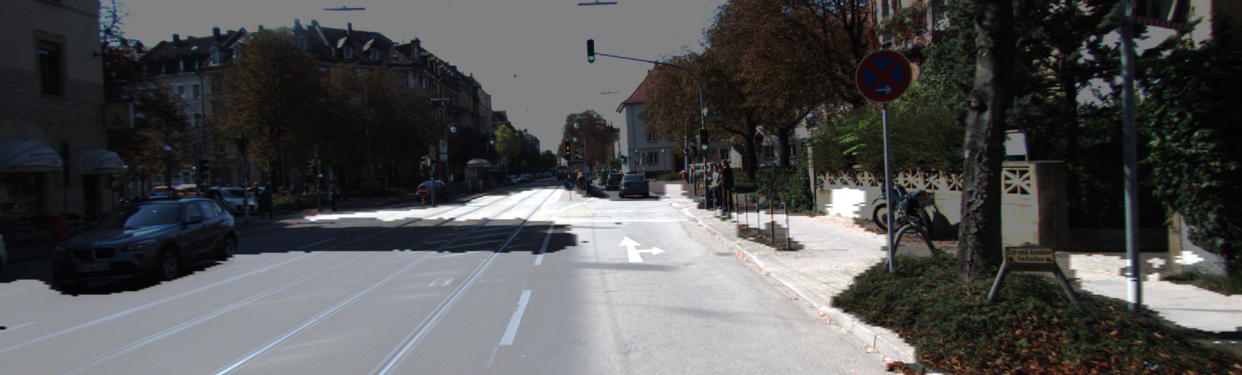

In [19]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)
output

# Unet++ (Backbone : Densenet121)

In [9]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

In [29]:
import tensorflow.keras.backend as K
from tensorflow.keras.applications import DenseNet121


def build_unetplus(input_shape=(None, None, 3), dropout_rate=0.1):

    backbone = DenseNet121(weights='imagenet',include_top=False,input_shape=input_shape)
    input = backbone.input
    start_neurons = 8

    conv4 = backbone.layers[311].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 32, (3, 3),
                   activation=None,
                   padding="same",
                   name='conv_middle')(pool4)
    convm = residual_block(convm, start_neurons * 32)
    convm = residual_block(convm, start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)

    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3),
                              strides=(2, 2),
                              padding="same")(convm)
    deconv4_up1 = Conv2DTranspose(start_neurons * 16, (3, 3),
                                  strides=(2, 2),
                                  padding="same")(deconv4)
    deconv4_up2 = Conv2DTranspose(start_neurons * 16, (3, 3),
                                  strides=(2, 2),
                                  padding="same")(deconv4_up1)
    deconv4_up3 = Conv2DTranspose(start_neurons * 16, (3, 3),
                                  strides=(2, 2),
                                  padding="same")(deconv4_up2)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4)

    uconv4 = Conv2D(start_neurons * 16, (3, 3),
                    activation=None,
                    padding="same")(uconv4)
    uconv4 = residual_block(uconv4, start_neurons * 16)
    #     uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)  #conv1_2

    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3),
                              strides=(2, 2),
                              padding="same")(uconv4)
    deconv3_up1 = Conv2DTranspose(start_neurons * 8, (3, 3),
                                  strides=(2, 2),
                                  padding="same")(deconv3)
    deconv3_up2 = Conv2DTranspose(start_neurons * 8, (3, 3),
                                  strides=(2, 2),
                                  padding="same")(deconv3_up1)
    conv3 = backbone.layers[139].output
    uconv3 = concatenate([deconv3, deconv4_up1, conv3])
    uconv3 = Dropout(dropout_rate)(uconv3)

    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None,
                    padding="same")(uconv3)
    uconv3 = residual_block(uconv3, start_neurons * 8)
    #     uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3),
                              strides=(2, 2),
                              padding="same")(uconv3)
    deconv2_up1 = Conv2DTranspose(start_neurons * 4, (3, 3),
                                  strides=(2, 2),
                                  padding="same")(deconv2)
    conv2 = backbone.layers[51].output
    uconv2 = concatenate([deconv2, deconv3_up1, deconv4_up2, conv2])

    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None,
                    padding="same")(uconv2)
    uconv2 = residual_block(uconv2, start_neurons * 4)
    #     uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3),
                              strides=(2, 2),
                              padding="same")(uconv2)
    conv1 = backbone.layers[4].output
    uconv1 = concatenate(
        [deconv1, deconv2_up1, deconv3_up2, deconv4_up3, conv1])

    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None,
                    padding="same")(uconv1)
    uconv1 = residual_block(uconv1, start_neurons * 2)
    #     uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)

    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3),
                             strides=(2, 2),
                             padding="same")(uconv1)
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None,
                    padding="same")(uconv0)
    uconv0 = residual_block(uconv0, start_neurons * 1)
    #     uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)

    uconv0 = Dropout(dropout_rate / 2)(uconv0)
    output_layer = Conv2D(1, (1, 1), padding="same",
                          activation="sigmoid")(uconv0)
    model = Model(input, output_layer, name="U_xecption")
    return model

In [30]:
model_path = "./model_save/seg_model_unet++.h5"

img_size = 224
model = build_unetplus(input_shape=(img_size,img_size,3),dropout_rate=0.5)

model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

29084464/29084464 [==============================] - 3s 0us/step
Epoch 1/100
22/22 [==============================] - 17s 232ms/step - loss: 0.7605 - val_loss: 0.6839
Epoch 2/100
22/22 [==============================] - 3s 157ms/step - loss: 0.6552 - val_loss: 0.6687
Epoch 3/100
22/22 [==============================] - 3s 157ms/step - loss: 0.5942 - val_loss: 0.6515
Epoch 4/100
22/22 [==============================] - 3s 156ms/step - loss: 0.5333 - val_loss: 0.6249
Epoch 5/100
22/22 [==============================] - 3s 156ms/step - loss: 0.4543 - val_loss: 0.5644
Epoch 6/100
22/22 [==============================] - 3s 157ms/step - loss: 0.3976 - val_loss: 0.4864
Epoch 7/100
22/22 [==============================] - 3s 157ms/step - loss: 0.3551 - val_loss: 0.4207
Epoch 8/100
22/22 [==============================] - 3s 158ms/step - loss: 0.3324 - val_loss: 0.3678
Epoch 9/100
22/22 [==============================] - 3s 158ms/step - loss: 0.2957 - val_loss: 0.3242
Epoch 10/100
22/22 [=====

IoU : 0.931225


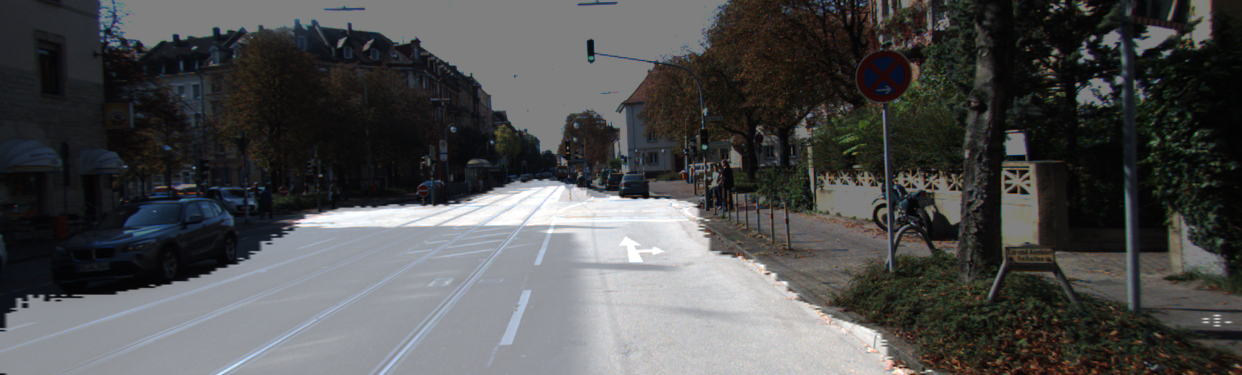

In [31]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)
output

# 모델 비교하기

In [35]:
unet_model_path = './model_save/seg_model_ori_unet.h5'
unetpp_model_path = './model_save/seg_model_unet++.h5'

In [36]:
unet_model = tf.keras.models.load_model(unet_model_path)
unetpp_model = tf.keras.models.load_model(unetpp_model_path)

In [37]:
unet_iou = []
for i in range(20):
    output, prediction, target = get_output(unet_model, 
                                            test_preproc, 
                                            image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
                                            output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
                                            label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
                                           )
    unet_iou.append(calculate_iou_score(target, prediction))

IoU : 0.750678
IoU : 0.750403
IoU : 0.692852
IoU : 0.615992
IoU : 0.537799
IoU : 0.500043
IoU : 0.323784
IoU : 0.674672
IoU : 0.653359
IoU : 0.687813
IoU : 0.655634
IoU : 0.641485
IoU : 0.614080
IoU : 0.796007
IoU : 0.605614
IoU : 0.797053
IoU : 0.828233
IoU : 0.850715
IoU : 0.444213
IoU : 0.651389


In [38]:
unetpp_iou = []
for i in range(20):
    output, prediction, target = get_output(unetpp_model, 
                                            test_preproc, 
                                            image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
                                            output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
                                            label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
                                           )
    unetpp_iou.append(calculate_iou_score(target, prediction))

IoU : 0.951986
IoU : 0.931225
IoU : 0.530207
IoU : 0.634275
IoU : 0.632303
IoU : 0.698977
IoU : 0.589244
IoU : 0.732054
IoU : 0.877931
IoU : 0.825787
IoU : 0.692985
IoU : 0.681441
IoU : 0.647931
IoU : 0.856525
IoU : 0.853211
IoU : 0.871703
IoU : 0.897327
IoU : 0.874761
IoU : 0.798246
IoU : 0.835832


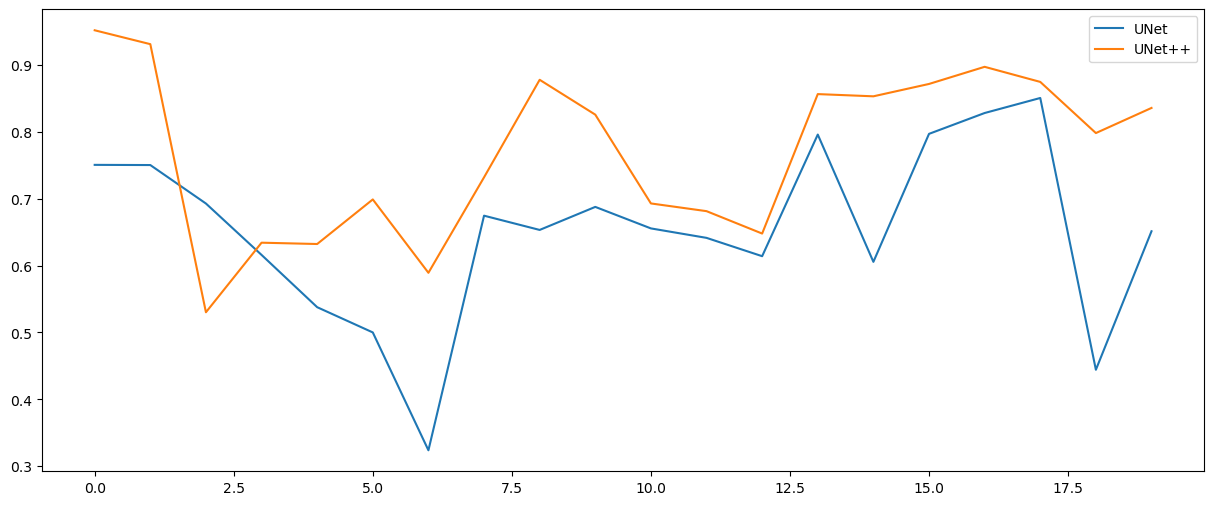

In [42]:
plt.figure(figsize=(15, 6))
plt.plot(unet_iou, label='UNet')
plt.plot(unetpp_iou, label='UNet++')
plt.legend()